In [1]:
import sys
import os
import numpy as np
import h5py
import scipy.io
import tensorflow as tf
from keras import ops
import keras
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
import keras_tuner as kt

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import math

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, average_precision_score
import sys
sys.path.append("/hpcnfs/data/GN2/gmandana/take2project/clip_2_electric_boogaloo/analysis/NN/Neural_Network_DNA_Demo")
sys.path.append("/hpcnfs/data/GN2/gmandana/bin/DeepRiPe_edited/Scripts/")
from helper import IOHelper, SequenceHelper

import random
#rs = 1234
rs = 2341234123
random.seed(rs)

2025-05-09 12:55:39.919673: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 12:55:42.479770: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 12:55:47.195870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 12:56:27.201913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def model_builder(hp):

	num_task=1
	left_dim=4
	right_dim=4
	num_units=50
	input_l=500

	nb_f_l = hp.Int('filters', min_value=100, max_value=460, step=60)
	#nb_f_l=[90,100]
	f_len_l=hp.Int('kernel_size', min_value=8, max_value=100, step=6)
	#f_len_l=[7,7]
	p_len_l=hp.Int('pool_size', min_value=4, max_value=10, step=2)
	#p_len_l=[4,10]
	s_l=hp.Int('strides', min_value=2, max_value=4, step=2)
	#s_l=[2,5]
	learning_rate=hp.Float("learning_rate", min_value=0.0005, max_value=0.002, sampling="log")
	# Tune the learning rate for the optimizer
	# Choose an optimal value from 0.01, 0.001, or 0.0001

	##### architecture

	left_input = Input(shape=(input_l,left_dim),name="left_input")

	left_conv1 = Conv1D(filters=nb_f_l,kernel_size=f_len_l, padding='valid',activation="relu",name="left_conv1")(left_input)
	left_pool1 = MaxPooling1D(pool_size=p_len_l, strides=s_l,name="left_pool1")(left_conv1)
	left_drop1 = Dropout(0.25,name="left_drop1")(left_pool1)

	conv_merged = Conv1D(filters=100, kernel_size= 5, padding='valid',activation="relu",name="conv_merged")(left_drop1)
	merged_pool = MaxPooling1D(pool_size=10, strides=5)(conv_merged)
	#conv_merged = Conv1D(filters=nb_f_l,kernel_size= f_len_l, padding='valid',activation="relu",name="conv_merged")(left_drop1)
	#merged_pool = MaxPooling1D(pool_size=p_len_l, strides=s_l)(conv_merged)
	merged_drop = Dropout(0.25)(merged_pool)
	merged_flat = Flatten()(merged_drop)

	hidden1 = Dense(250, activation='relu',name="hidden1")(merged_flat)
	output = Dense(num_task, activation='sigmoid',name="output")(hidden1)
	model = Model(inputs=left_input, outputs=output)
	print(model.summary())

	model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

	return model

def create_class_weight(labels_dict,total,mu=0.15):
    keys = labels_dict.keys()
    class_weight = dict()
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

@keras.saving.register_keras_serializable(package="my_package", name="myprecision")
def myprecision(y_true, y_pred):
	true_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true * y_pred, 0, 1)))
	predicted_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
	return precision

@keras.saving.register_keras_serializable(package="my_package", name="myrecall")
def myrecall(y_true, y_pred):
	true_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true * y_pred, 0, 1)))
	possible_positives = tf.math.reduce_sum(tf.math.round(tf.keras.ops.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
	return recall


In [3]:
ntask = 1

### read in the sequence data
model_path = "/hpcnfs/data/GN2/gmandana/bin/restr_NN/"
fg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/fg_v6.fa", uppercase=True)
bg_fasta_data = IOHelper.get_fastas_from_file("/hpcnfs/data/GN2/gmandana/bin/4.1.0/home/ieo5559/unifiedCLIP/NN_files/siW/bg_v6.fa", uppercase=True)

sequence_length = len(fg_fasta_data.sequence[0])

fg_seq_matrix = SequenceHelper.do_one_hot_encoding(fg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)
bg_seq_matrix = SequenceHelper.do_one_hot_encoding(bg_fasta_data.sequence, sequence_length, SequenceHelper.parse_alpha_to_seq)

seq_matrix = np.concatenate((fg_seq_matrix ,bg_seq_matrix))

In [4]:
### generate labels
Y = np.hstack([np.ones((np.shape(fg_seq_matrix)[0], )), np.zeros((np.shape(bg_seq_matrix)[0], ))])
#Y = np.hstack([np.zeros((np.shape(fg_seq_matrix)[0], )), np.ones((np.shape(bg_seq_matrix)[0], ))])

X_train, X_test, y_train , y_test = train_test_split(seq_matrix, Y, test_size = 0.3, random_state = rs)

In [ ]:
with open("/hpcnfs/data/GN2/gmandana/bin/restr_NN/tuner/siW_v6/X_test.pkl", 'wb') as handle:
    pickle.dump(X_test, handle)
with open("/hpcnfs/data/GN2/gmandana/bin/restr_NN/tuner/siW_v6/y_test.pkl", 'wb') as handle:
    pickle.dump(y_test, handle)

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
labels_dict = dict(zip(unique, counts))
class_weight=create_class_weight(labels_dict, np.shape(y_train)[0], mu=0.5)

In [6]:
###### tuning
tuner = kt.Hyperband(model_builder,
                     objective=['val_accuracy'],
                     max_epochs=10,
                     factor=3,
                     directory="/hpcnfs/data/GN2/gmandana/bin/restr_NN/tuner/siW_v6",
                     overwrite=False)

earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[earlystopper], class_weight=class_weight)

Trial 26 Complete [00h 02m 20s]
multi_objective: -0.7593269944190979

Best multi_objective So Far: -0.8237015604972839
Total elapsed time: 00h 24m 06s


In [7]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""filter num: {best_hps.get('filters')}, kernel size: {best_hps.get('kernel_size')}, 
pool size: {best_hps.get('pool_size')}, stride: {best_hps.get('strides')}, learning rate: {best_hps.get('learning_rate')}.""")

filter num: 100, kernel size: 8, 
pool size: 8, stride: 4, learning rate: 0.001138901218988278.


In [8]:
########## build model with optimal hyperparams
model = tuner.hypermodel.build(best_hps)

checkpointer = ModelCheckpoint(filepath = os.path.join(model_path, "siW_NN_v5.keras"), verbose=1, save_best_only=True)

####### train

history = model.fit(X_train, y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_test,y_test), 
    class_weight=class_weight, verbose=2, 
    callbacks=[checkpointer,earlystopper])

model.save(os.path.join(model_path, "siW_NN_v5" + ".keras"))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ left_input (InputLayer)         │ (None, 500, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ left_conv1 (Conv1D)             │ (None, 493, 100)       │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ left_pool1 (MaxPooling1D)       │ (None, 122, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ left_drop1 (Dropout)            │ (None, 122, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_merged (Conv1D)            │ (None, 118, 100)       │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 250)            │       550,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,901 (2.30 MB)

 Trainable params: 603,901 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20

Epoch 1: val_loss improved from inf to 0.54574, saving model to /hpcnfs/data/GN2/gmandana/bin/restr_NN/siW_NN_v5.keras
214/214 - 7s - 34ms/step - accuracy: 0.6882 - loss: 0.5966 - val_accuracy: 0.7395 - val_loss: 0.5457
Epoch 2/20

Epoch 2: val_loss improved from 0.54574 to 0.50539, saving model to /hpcnfs/data/GN2/gmandana/bin/restr_NN/siW_NN_v5.keras
214/214 - 5s - 21ms/step - accuracy: 0.7311 - loss: 0.5478 - val_accuracy: 0.7651 - val_loss: 0.5054
Epoch 3/20

Epoch 3: val_loss improved from 0.50539 to 0.49771, saving model to /hpcnfs/data/GN2/gmandana/bin/restr_NN/siW_NN_v5.keras
214/214 - 4s - 20ms/step - accuracy: 0.7527 - loss: 0.5149 - val_accuracy: 0.7631 - val_loss: 0.4977
Epoch 4/20

Epoch 4: val_loss improved from 0.49771 to 0.44725, saving model to /hpcnfs/data/GN2/gmandana/bin/restr_NN/siW_NN_v5.keras
214/214 - 4s - 20ms/step - accuracy: 0.7747 - loss: 0.4797 - val_accuracy: 0.7750 - val_loss: 0.4472
Epoch 5/20

Epoch 5: val_loss improved from 0.44725 to 

## visualise attributions

In [20]:
model=load_model(os.path.join(model_path, "siW_NN_v5.keras"), custom_objects={"custom_fn": myprecision, "custom_fn": myrecall})
from igrads import integrated_gradients
from igrads import plot_sequence_attribution
np.set_printoptions(suppress=True)
inp_dim_1 = 500
pred = model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [21]:
np.unique(np.ceil(pred).flatten() == y_test, return_counts=True)

(array([False,  True]), array([1482, 1447]))

In [22]:
indices = range(0,10)
print(y_test[indices])
model.predict(X_test[indices].reshape(10,inp_dim_1,4))
#model.predict(np.zeros((1,500,4)))

[1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


array([[0.9997588 ],
       [0.00265309],
       [0.29594135],
       [0.94419146],
       [0.8017935 ],
       [0.6107348 ],
       [0.94199634],
       [0.9862825 ],
       [0.9647889 ],
       [0.99250895]], dtype=float32)

In [31]:
ind = 9

print(model.predict(X_test[ind].reshape(1,inp_dim_1,4)))
baseline = np.full((inp_dim_1,4), 0.0)
#baseline = np.full((500,4), 0.25)
attriutions = integrated_gradients(X_test[ind], baseline, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
[[0.99250895]]


findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Ro

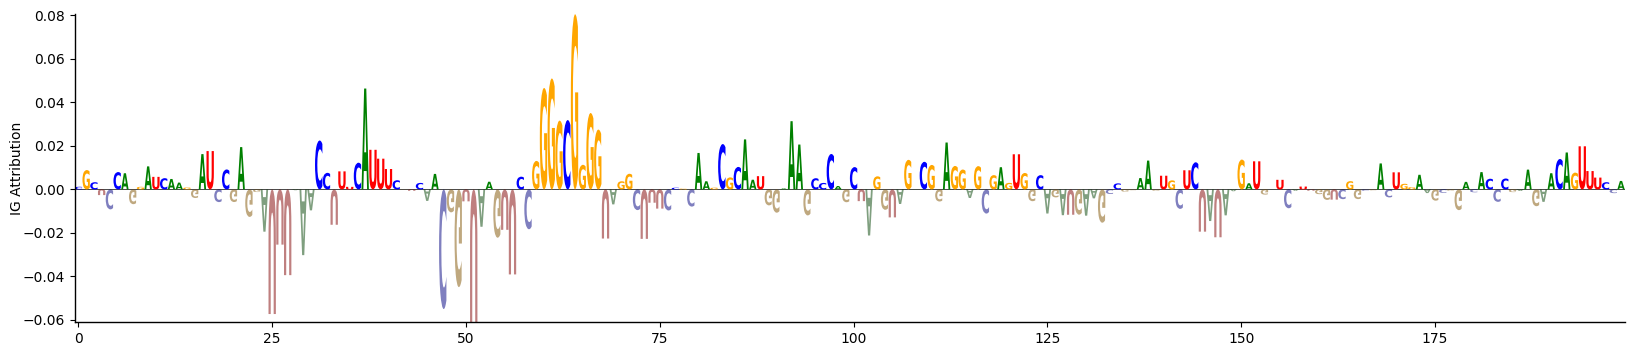

In [34]:
%matplotlib inline
plot_sequence_attribution(attriutions.numpy()[50:250,:], sigma=['A', 'C', 'U', 'G'])
#plot_sequence_attribution(attriutions.numpy()[400:600,:], sigma=['A', 'C', 'U', 'G'])

In [ ]:
baselines = X_test[np.where(y_test == 0)][np.random.choice(range(0,5000), size=500, replace=False)]

attributions_agg = np.asarray([integrated_gradients(X_test[ind], i, model) for i in baselines])

In [ ]:
final_att = np.mean(attributions_agg, axis=0)*X_test[ind]
#plot_sequence_attribution(final_att, sigma=['A', 'C', 'U', 'G'])

In [ ]:
sums = slidingwinsum(X_test[ind], attriutions, winsize=6)
#plot_sequence_attribution(sums[0:200], sigma=['A', 'C', 'U', 'G'])

In [ ]:
#model.predict(np.zeros((1,inp_dim_1,4)))
#np.sum(attriutions)

## stuff

In [ ]:
###set negative attributions to zero
#attriutions.numpy().clip(min=0)

###hard attribution thresh
att = slidingwinsum(X_test[ind], attriutions, winsize=6)

## just get indices where its greater than the thresh, then split that into submatrices and reverse one-hot encode
indices = np.sum(att, axis=1) > 0.1*np.sum(attriutions)
indRLE = rle(indices)
indRLE2 = [i[indRLE[2]] for i in indRLE]
indRLE3 = [i[indRLE2[0] > 5] for i in indRLE2]

### indRLE3[1] are the start coords, indRLE3[0] are the lengths
rel_kmers = [att[i[0]:i[0]+i[1]] for i in zip(indRLE3[1], indRLE3[0])]

In [ ]:
agg_attr(X_test[ind], attriutions, winsize=6)

In [ ]:
############# function to aggregate attributions

def slidingwinsum(seq, arr, winsize):
    
    index_bool = np.array(seq, dtype=bool)
    flat = arr[index_bool]
    y = np.abs(np.convolve(flat,np.ones(winsize,dtype=int),'same'))
    yy = np.multiply(y, np.sign(flat))
    return np.asarray([np.full((1,4), x) for x in yy]).reshape((500,4))*seq

# from https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

def vecs2dna(seq_vecs):
    if len(seq_vecs.shape) == 2:
        seq_vecs = np.reshape(seq_vecs, (seq_vecs.shape[0], 4, -1))
    elif len(seq_vecs.shape) == 4:
        seq_vecs = np.reshape(seq_vecs, (seq_vecs.shape[0], 4, -1))
    seqs = []
    for i in range(seq_vecs.shape[0]):
        seq_list = ['']*seq_vecs.shape[2]
        for j in range(seq_vecs.shape[2]):
            if seq_vecs[i,0,j] == 1:
                seq_list[j] = 'A'
            elif seq_vecs[i,1,j] == 1:
                seq_list[j] = 'C'
            elif seq_vecs[i,2,j] == 1:
                seq_list[j] = 'T'
            elif seq_vecs[i,3,j] == 1:
                seq_list[j] = 'G'
            elif seq_vecs[i,:,j].sum() == 1:
                seq_list[j] = 'N'
            else:
                print('Malformed position vector: ', seq_vecs[i,:,j], 'for sequence %d position %d' % (i,j), file=sys.stderr)
        seqs.append(''.join(seq_list))
    return seqs

def agg_attr(seq, baseline, model, winsize):

    ##### we want to first set a threshold and take attributions above a certain value
    ## let's say 10% of the sum of all attrubtions - for a strong positive prediction 
    ## this would be F(x) - F(0), in our case approx. 0.6. so 10% of that is 0.06
    attr = integrated_gradients(seq, baseline, model)

    ###hard attribution thresh
    att = slidingwinsum(seq, attr, winsize=6)

    ## just get indices where its greater than the thresh, then split that into submatrices and reverse one-hot encode
    indices = np.sum(att, axis=1) > 0.1*np.sum(attr)
    indRLE = rle(indices)
    indRLE2 = [i[indRLE[2]] for i in indRLE]
    indRLE3 = [i[indRLE2[0] > 5] for i in indRLE2]

    ### indRLE3[1] are the start coords, indRLE3[0] are the lengths
    rel_kmers = [att[i[0]:i[0]+i[1]] for i in zip(indRLE3[1], indRLE3[0])]
    
    one_hot_rel_kmers = [np.ceil(i) for i in rel_kmers]
    kmers = [vecs2dna(i) for i in one_hot_rel_kmers]
    kmers_concat = ["".join(j) for j in kmers]

    ### positional filtering (i.e., first 100bp, 100-200bp, etc...?)
    
    ### set a width? how do we do this?

    return(kmers_concat)

def flatten(xss):
    return [x for xs in xss for x in xs]


In [ ]:
### get good predictions
pred = model.predict(X_test)
## get true positives... then get the sequences corresponding to them
mymat = y_test*np.reshape(pred, ((np.shape(pred)[0])))
seqs_to_explain = X_test[np.where(mymat > 0.9)]
np.shape(seqs_to_explain)

In [ ]:
##### run the agg 
list_of_lists_of_kmers = [agg_attr(i, baseline, model, 6) for i in seqs_to_explain]
coll_kmers = flatten(list_of_lists_of_kmers)

In [ ]:
##### collapse and export
with open("/hpcnfs/data/GN2/gmandana/bin/restr_NN/imp_kmers.fa", "w") as f:
    for i in range(len(coll_kmers)):
        f.write(">seq{0}\n{1}\n".format(i, coll_kmers[i]))